## Test Predizione Traiettoria Navi (senza nessun attacco)

#### Configurazione dell'Ambiente per l'Analisi e la Valutazione
Questo codice prepara l'ambiente di lavoro assicurando che tutte le risorse software e hardware siano pronte per caricare il modello LSTM addestrato e per eseguire l'analisi sui dati di test, senza nessun attacco 


In [3]:
import pandas as pd
import numpy as np
import glob
import os
import gc
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.decomposition import PCA
import random



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU e Mixed Precision Attivate.")
    except RuntimeError as e:
        print(e)

INPUT_DIR = '../Pre-Elaborazione Dati/Dataset' 
SCALER_PATH = 'scaler.joblib' 
MODEL_PATH = 'lstm_autoencoder_best.keras'
LOG_PATH = 'training_log.csv'

COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
WINDOW_SIZE = 30
BATCH_SIZE = 64 

all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24] 

print(f"File di Test selezionati: {len(TEST_FILES)}")

2025-11-21 12:26:01.290727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 12:26:01.540657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 12:26:02.745085: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU e Mixed Precision Attivate.
File di Test selezionati: 4


#### Analisi Post-Addestramento: Tracciamento delle Curve di Apprendimento
Questa sezione del codice è dedicata alla valutazione diagnostica del processo di training del modello. L'obiettivo è caricare i dati registrati durante l'addestramento e generare un grafico per capire se il modello ha appreso in modo efficace, stabile e senza incorrere in overfitting.  

**Generazione del Grafico Diagnostico:** Viene recuperato il file che descrive l'andamento di ogni epoca dell'addesstramento e ne ricava un grafico rappresentativo degli andamenti della **Training loss** e **Validation loss**.  
 Il codice utilizza la libreria Matplotlib per visualizzare le "Curve di Apprendimento" :
   * **Asse Orizzontale (X):** Rappresenta le Epoche.  
   * **Asse Verticale (Y):** Rappresenta la Loss (MAE), che è l'errore medio di ricostruzione del modello.  
   
   Vengono tracciate due linee fondamentali sul grafico:
     1. **Training Loss (Linea Blu):** 
     2. **Validation Loss (Linea Arancione):**

**Interpretazione Diagnostica:** Analizzando il grafico delle curve di apprendimento, possiamo trarre conclusioni dirette sull'efficacia del processo di training del nostro LSTM Autoencoder:

   * **Fase di Apprendimento Stabile (Epoche 0-12):** Nelle prime dodici epoche, la Training Loss (blu) e la Validation Loss (arancione) sono molto vicine tra loro, oscillando tra 0.02 e 0.08. Questa vicinanza indica che **il modello sta generalizzando bene:** l'errore sui dati non visti (Validation Loss) è quasi identico all'errore sui dati visti (Training Loss). **Il modello non sta memorizzando eccessivamente i dati di training.** 
   **Il punto di migliore performance per entrambi gli errori è stato raggiunto all'Epoca 12**, dove la val_loss raggiunge il suo minimo (circa 0.03). Questo è il punto in cui il modello ha la massima capacità di ricostruire le traiettorie normali.

   * **Rilevamento di Anomalie/Interruzione (Epoche 13-17):**
     A partire dall'Epoca 13, si verifica un incremento improvviso e drastico sia della Training Loss che della Validation Loss. L'errore passa da circa 0.03 a quasi 0.7. Qui entra in gioco l'**EarlyStopping** che ferma l'addestramento perchè non ci sono stati miglioramenti nelle ultime 5 epoche.

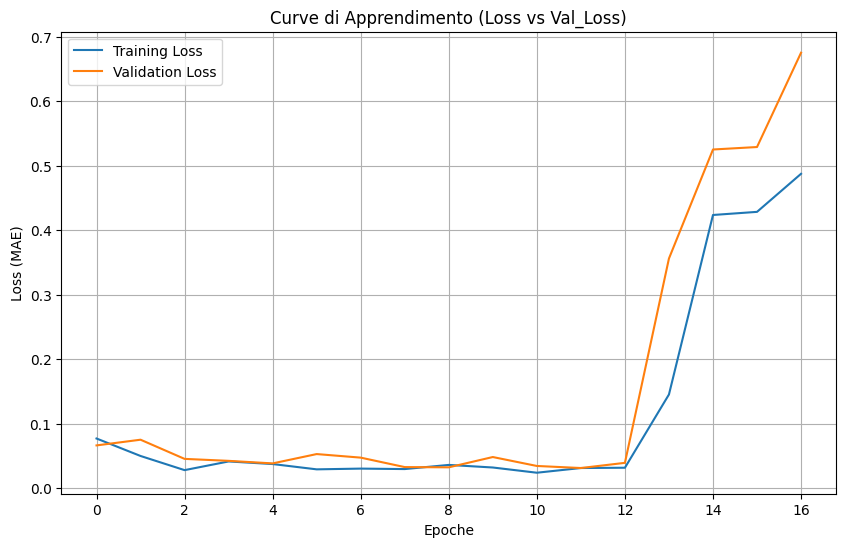

In [4]:
try:
    history = pd.read_csv(LOG_PATH)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Curve di Apprendimento (Loss vs Val_Loss)')
    plt.xlabel('Epoche')
    plt.ylabel('Loss (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
except FileNotFoundError:
    print("File di log non trovato. Hai eseguito l'addestramento?")

#### Definizione delle Funzioni del Data Generator
Queste funzioni lavorano insieme per rendere l'addestramento del modello LSTM su un dataset molto grande possibile, efficiente e accurato, fornendo sequenze temporali complete e normalizzate, garantendo al contempo che l'addestramento sia correttamente dimensionato.

In [5]:
def calculate_steps_per_epoch(file_paths, window_size, batch_size):
    """
    Scansiona tutti i file in modo efficiente (RAM-safe) per calcolare
    il numero totale di finestre (campioni) che verranno generate,
    e da lì calcola il numero di "steps" (batch) per epoca.
    Usa il metodo Counter.update(Series) che sappiamo funzionare.
    """
    print(f"--- Calcolo Steps per {len(file_paths)} file ---")
    
    total_lengths = Counter()
    
    #Trova le lunghezze di tutte le 4.3M traiettorie
    for i, file_path in enumerate(file_paths):
        print(f"  Scansione lunghezze file {i+1}/{len(file_paths)}...", end='\r')
        try:
            df = pd.read_parquet(file_path, columns=['TrajectoryID'])
            total_lengths.update(df['TrajectoryID'])
            del df
            gc.collect()
        except Exception as e:
            print(f"Errore nel leggere {file_path}: {e}")

    print("\nScansione completata.")

    #Calcola il numero totale di finestre
    total_windows = 0
    for length in total_lengths.values():
        if length >= window_size:
            total_windows += (length - window_size + 1)
            
    #Calcola gli steps
    steps = int(np.ceil(total_windows / batch_size))
    
    print(f"Trovate {total_windows:,} finestre totali.")
    print(f"Steps per Epoca (Batch Size {batch_size}): {steps}")
    print("-" * 75)
    return steps


def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


#### Caricamento risorse

In [6]:
# Carica lo Scaler
scaler = joblib.load(SCALER_PATH)
print("Scaler caricato.")

# Carica il Modello
model = tf.keras.models.load_model(MODEL_PATH)
print("Modello caricato.")
model.summary()

Scaler caricato.


I0000 00:00:1763724374.273172    5916 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Modello caricato.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 4)          │           132 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,570 (154.58 KB)

 Trainable params: 13,188 (51.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,382 (103.07 KB)

#### Test Quantitativo
1. **Calcolo del Workload di Test**
2. **Preparazione del Data generator**
3. **Esecuzione della Valutazione**
4. **Risultato e Implicazioni per il Rilevamento delle Anomalie**.  
  Dopo l'esecuzione della valutazione, abbiamo ottenuto il **$\text{Mean Absolute Error (MAE) di } 0.03159$**.  
  Un $\text{MAE}$ così basso e confrontabile con la Validation Loss minima vista nel grafico (circa 0.03) conferma che il modello ha generalizzato in modo eccellente. La capacità del modello di ricostruire sequenze normali sui dati mai visti è molto alta. Questo valore stabilisce la nostra soglia di base (baseline) per la normalità.

In [5]:
test_steps = calculate_steps_per_epoch(TEST_FILES, WINDOW_SIZE, BATCH_SIZE)

test_gen = data_generator_v(
    file_paths=TEST_FILES,
    scaler=scaler,
    features=COLONNE_FEATURES,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_files=False
)

print(f"\nValutazione su {test_steps}")
test_loss = model.evaluate(test_gen, steps=test_steps, verbose=1)

print(f"Mean Absolute Error (MAE): {test_loss:.5f}")

--- Calcolo Steps per 4 file ---
  Scansione lunghezze file 4/4...
Scansione completata.
Trovate 110,429,714 finestre totali.
Steps per Epoca (Batch Size 64): 1725465
---------------------------------------------------------------------------

Valutazione su 1725465
     20/1725465 ━━━━━━━━━━━━━━━━━━━━ 1:16:52 3ms/step - loss: 0.0113    

2025-11-20 13:49:29.889869: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-11-20 13:49:29.923137: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


1725465/1725465 ━━━━━━━━━━━━━━━━━━━━ 5526s 3ms/step - loss: 0.0316
Mean Absolute Error (MAE): 0.03159


#### Test Qualitativo
L'obiettivo è generare un grafico che metta a confronto la traiettoria di input reale con la traiettoria ricostruita dal modello (l'output dell'Autoencoder).

1. **Estrazione e Predizione del Batch**
   * Estrazione del Campione: Viene estratto il primo batch di finestre temporali dal generatore di test *(test_gen)*. Questo X_batch contiene sequenze di traiettorie normalizzate.

   * Predizione (Inferenza): Il modello LSTM Autoencoder elabora l'intero batch e produce pred_batch. Poiché è un Autoencoder, la predizione non è un punto futuro, ma la ricostruzione di ciò che il modello pensa che la traiettoria di input dovesse essere.

2. **Denormalizzazione dei Dati**.  
  Per l'analisi umana, i dati utilizzati dal modello vengono riportati alla loro scala originale (es. Latitudine in gradi, Velocità in nodi) applicando l'inverse_transform dello scaler.

3. **Generazione del Grafico di Confronto:**
   * Viene creata una figura complessa che mostra il confronto tra la traiettoria Reale (GPS) e la traiettoria Ricostruita dall'AI.
     
    1. **Dinamica Velocità:**
       * Il modello Ricostruito segue l'andamento della Reale con una buona fedeltà, anche se l'AI tende a produrre una curva più smussata e meno "a gradino" rispetto al dato grezzo reale. Questo è tipico degli Autoencoder che filtrano il rumore. L'errore di ricostruzione tra i due segnali è minimo.
    2. **Dinamica Direzione:**
       * Similmente alla velocità, la Ricostruita segue la tendenza della Reale. Si notano delle discrepanze più marcate, ma nel complesso, l'AI riproduce con successo il range e la variazione della rotta della nave.

4. **Conclusione Qualitativa**.  
  L'ispezione visiva di questo campione di successo convalida l'efficacia del training. L'Autoencoder ha imparato a ricostruire la dinamica delle traiettorie normali con un livello di errore molto basso.



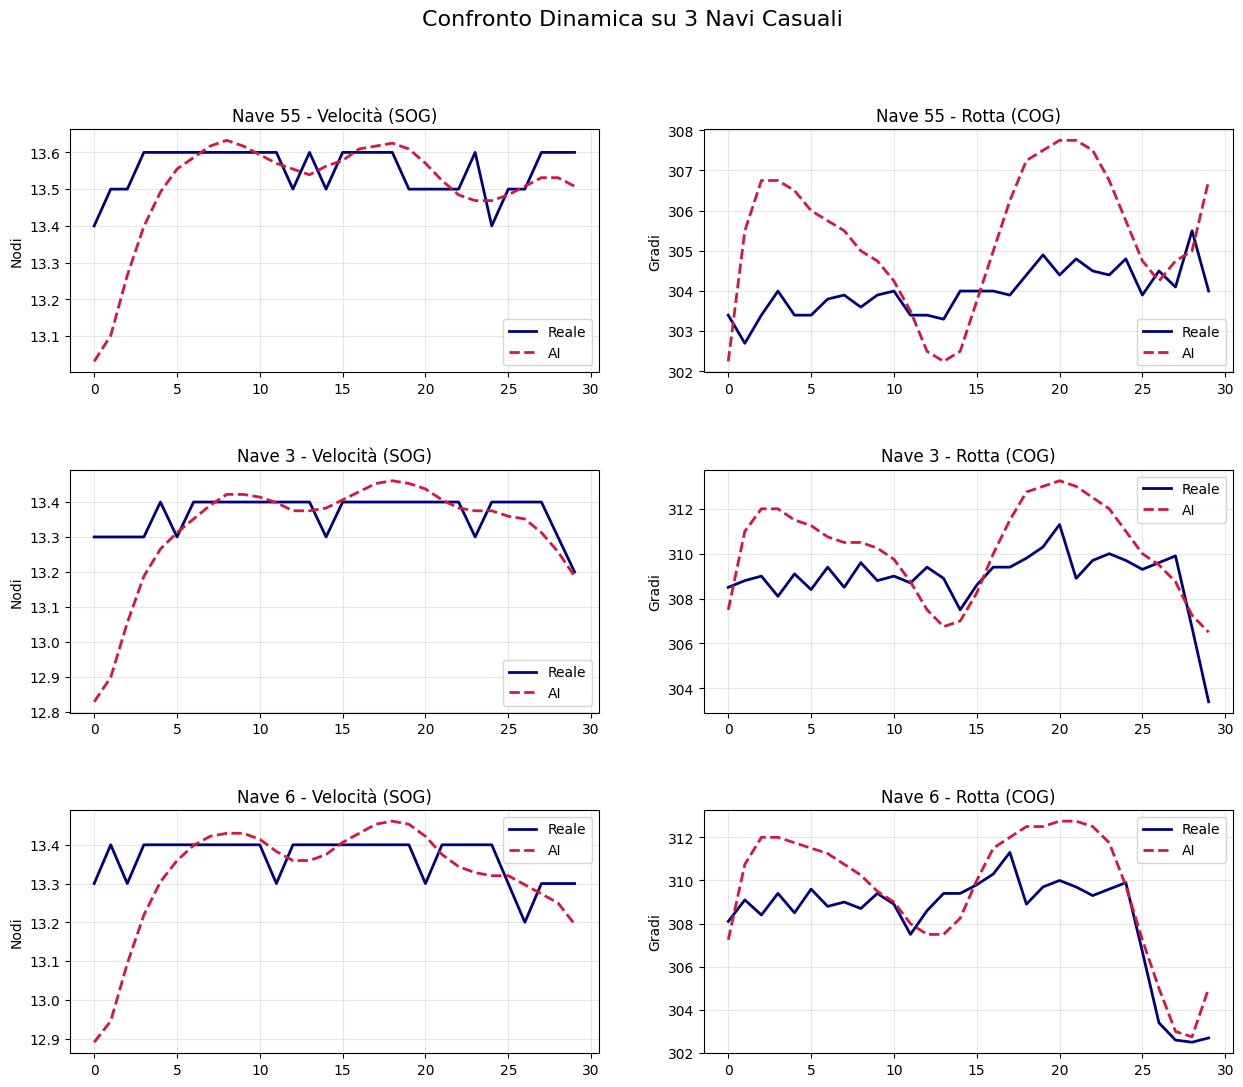

In [8]:
# Batch di dati
test_gen = data_generator_v(
    file_paths=TEST_FILES,
    scaler=scaler,
    features=COLONNE_FEATURES,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_files=False
)

X_batch, _ = next(test_gen)
pred_batch = model.predict(X_batch, verbose=0)

# Denormalizza tutto subito (per avere nodi e gradi)
sh = X_batch.shape
X_real = scaler.inverse_transform(X_batch.reshape(-1, sh[2])).reshape(sh)
P_real = scaler.inverse_transform(pred_batch.reshape(-1, sh[2])).reshape(sh)

# Scegliamo 3 navi a caso dal batch da mostrare
num_esempi = 3
indices = random.sample(range(len(X_real)), num_esempi)

# Plot
fig, axes = plt.subplots(nrows=num_esempi, ncols=2, figsize=(15, 4 * num_esempi))
plt.subplots_adjust(hspace=0.4)

for i, idx in enumerate(indices):
    # Dati della nave corrente
    real = X_real[idx]
    pred = P_real[idx]
    
    # Colonna 1: Velocità (SOG) - Indice 2
    axes[i, 0].plot(real[:, 2], label='Reale', color='navy', linewidth=2)
    axes[i, 0].plot(pred[:, 2], label='AI', color='crimson', linestyle='--', linewidth=2)
    axes[i, 0].set_title(f"Nave {idx} - Velocità (SOG)")
    axes[i, 0].set_ylabel("Nodi")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Colonna 2: Rotta (COG) - Indice 3
    axes[i, 1].plot(real[:, 3], label='Reale', color='navy', linewidth=2)
    axes[i, 1].plot(pred[:, 3], label='AI', color='crimson', linestyle='--', linewidth=2)
    axes[i, 1].set_title(f"Nave {idx} - Rotta (COG)")
    axes[i, 1].set_ylabel("Gradi")
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.suptitle(f"Confronto Dinamica su {num_esempi} Navi Casuali", fontsize=16)
plt.show()

### Definizione della Baseline: Distribuzione Statistica degli Errori di Ricostruzione
Questo codice esegue una simulazione statistica della performance del modello su un campione rappresentativo di dati normali (test_gen). L'obiettivo non è misurare un singolo $\text{MAE}$ medio, ma capire come l'errore è distribuito quando il modello elabora migliaia di finestre temporali legittime.

1. **Calcolo Campionario dell'Errore (Simulazione)**
   * **Campionamento Esteso:** Invece di eseguire un unico model.evaluate() (che dà solo la media), il codice elabora 1000 batch di dati di test. Poiché ogni batch contiene 64 finestre temporali, questo campiona circa 64.000 finestre in totale.
   * **Calcolo dell'Errore per Sequenza:** Per ogni singola finestra temporale *(X_batch)*, viene calcolato l'errore assoluto medio ($\text{MAE}$) tra l'input reale e la sua ricostruzione da parte del modello. Questo è l'errore che l'Autoencoder ha commesso per quella specifica traiettoria.
   * **Raccolta Dati:** Tutti i 64.000 errori individuali vengono raccolti nella lista `errori_normali`.

2. **Generazione dell'Istogramma di Distribuzione**
Il codice utilizza la libreria **Seaborn** per visualizzare questa grande raccolta di errori sotto forma di istogramma e densità (la curva verde continua):
   * **Istogramma:** Mostra il conteggio (asse Y) di quante traiettorie hanno generato un determinato livello di errore (asse X).
   * **Linea della Media:** Viene tracciata una linea tratteggiata rossa che indica il valore medio di tutti gli errori raccolti.

3. **Analisi dell'Output Grafico (Baseline)**
Il grafico **"Distribuzione dell'Errore su Dati Normali (Baseline)"** rivela la firma statistica della normalità:
   * **Forma della Distribuzione:** La curva è fortemente asimmetrica e concentrata a sinistra, con un picco molto alto vicino allo zero. Questa forma è ideale, perché indica che la stragrande maggioranza delle traiettorie normali viene ricostruita con un errore estremamente basso.
   * **Media e Baseline:** La linea rossa tratteggiata identifica la media degli errori di ricostruzione, che è stata calcolata come:$$\text{Media degli Errori Normali: } 0.0171$$
   * **Rilevamento Anomalie:** Il punto cruciale di questa analisi è la definizione della soglia. Dato che la quasi totalità degli errori normali si concentra sotto un certo valore, possiamo scegliere una soglia per definire l'anomalia.

Calcolo distribuzione errori su campione statistico...


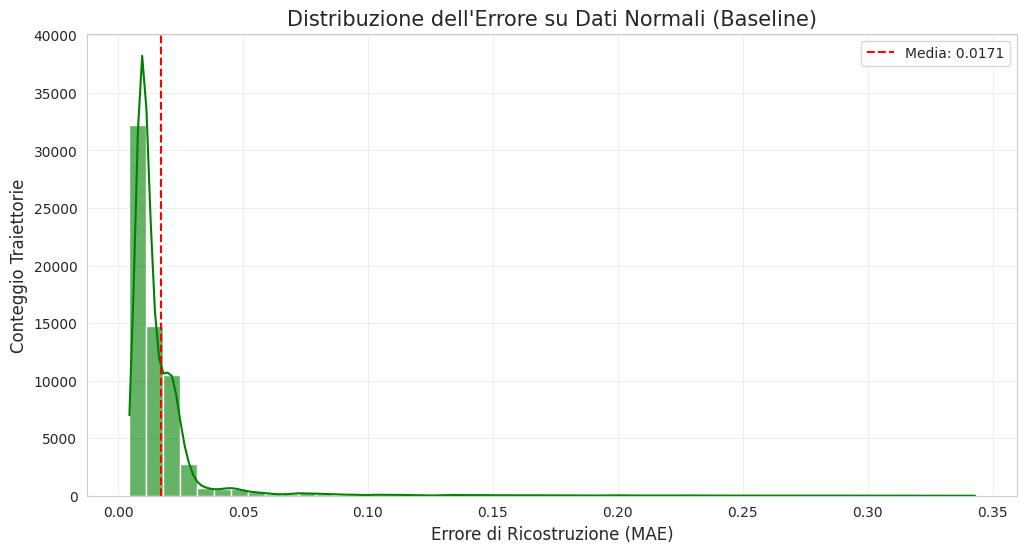

In [43]:
print("Calcolo distribuzione errori su campione statistico...")
errori_normali = []

for _ in range(1000): #Analizzo 1000 batch
    X_batch, _ = next(test_gen)
    pred = model.predict(X_batch, verbose=0)
    mae = np.mean(np.abs(X_batch - pred), axis=(1, 2))
    errori_normali.extend(mae)

# Plot Istogramma
plt.figure(figsize=(12, 6))
sns.histplot(errori_normali, bins=50, kde=True, color='green', alpha=0.6)
plt.axvline(np.mean(errori_normali), color='red', linestyle='--', label=f'Media: {np.mean(errori_normali):.4f}')
plt.title("Distribuzione dell'Errore su Dati Normali (Baseline)", fontsize=15)
plt.xlabel("Errore di Ricostruzione (MAE)", fontsize=12)
plt.ylabel("Conteggio Traiettorie", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Validazione Avanzata: Correlazione e Stabilità Temporale dell'Errore
Questa fase di analisi utilizza un singolo batch di dati di test per eseguire due verifiche critiche, assicurando che il modello sia robusto, non solo in media, ma anche nella ricostruzione di ogni singolo punto della sequenza.

1. **Analisi di Correlazione (Scatter Plots)**
Il primo set di grafici confronta il Valore Reale di una caratteristica con il Valore Predetto (Ricostruito) dal modello per ogni singolo punto dati all'interno del batch. 
    * **Processo:** I valori di Velocità ($\text{SOG}$) e Rotta ($\text{COG}$) di tutte le sequenze del batch vengono "appiattiti" in un unico array e tracciati uno contro l'altro. La linea rossa tratteggiata rappresenta la Perfetta Corrispondenza ($y=x$), dove il valore ricostruito è identico al valore reale.
    * **Correlazione Velocità ($\text{SOG}$):** I punti blu sono quasi perfettamente allineati lungo la linea rossa.Questo significa che, se il valore reale della velocità in un dato istante è X, il modello lo ricostruisce con una precisione estremamente alta. Questo conferma che l'Encoder e il Decoder hanno imparato la rappresentazione intrinseca della dinamica della velocità.
    * **Correlazione Rotta ($\text{COG}$):** Anche qui, i punti verdi sono fortemente concentrati sulla linea rossa. Si osserva una leggera dispersione maggiore rispetto alla velocità, soprattutto ai valori estremi (vicino a $-0.5$ e $0.1$ normalizzati), ma la correlazione complessiva è eccellente.
    * **Conclusione:** La forte correlazione visibile su entrambi i grafici è una prova definitiva della validità del modello, confermando che l'errore basso ($\text{MAE} \approx 0.03$) non è dovuto a una media fortuita, ma a una ricostruzione accurata punto per punto.

2. **Stabilità della Ricostruzione nel Tempo (MAE per Step)** 
Il secondo grafico analizza se la precisione del modello varia in base alla posizione del punto dati all'interno della finestra temporale di 30 step.
   * **Processo:** Viene calcolato l'Errore Medio Assoluto ($\text{MAE}$) per ogni step temporale (da 1 a 30) su tutti i campioni del batch. Questo produce quattro curve.
   * **Analisi delle Posizioni (Latitudine e Longitudine):** Le linee blu e arancione (posizione) mostrano un $\text{MAE}$ estremamente basso (tra $0.001$ e $0.005$) e molto stabile. Questo indica che la ricostruzione della posizione assoluta è eccezionalmente precisa lungo l'intera sequenza.
   * **Analisi delle Dinamiche (Velocità e Rotta):** Le linee verde ($\text{SOG}$) e rossa ($\text{COG}$) hanno un $\text{MAE}$ maggiore, ma ciò è atteso, in quanto le variabili dinamiche sono intrinsecamente più rumorose e difficili da prevedere. L'errore medio si mantiene generalmente sotto lo $0.03$. Si notano delle variazioni nell'errore (picchi per la rotta intorno allo step 1 e allo step 24). Questo suggerisce che il modello ha leggermente più difficoltà a ricostruire la Rotta all'inizio e verso la fine della finestra, ma la stabilità è elevata nella maggior parte della sequenza.

Generazione grafici di analisi profonda...


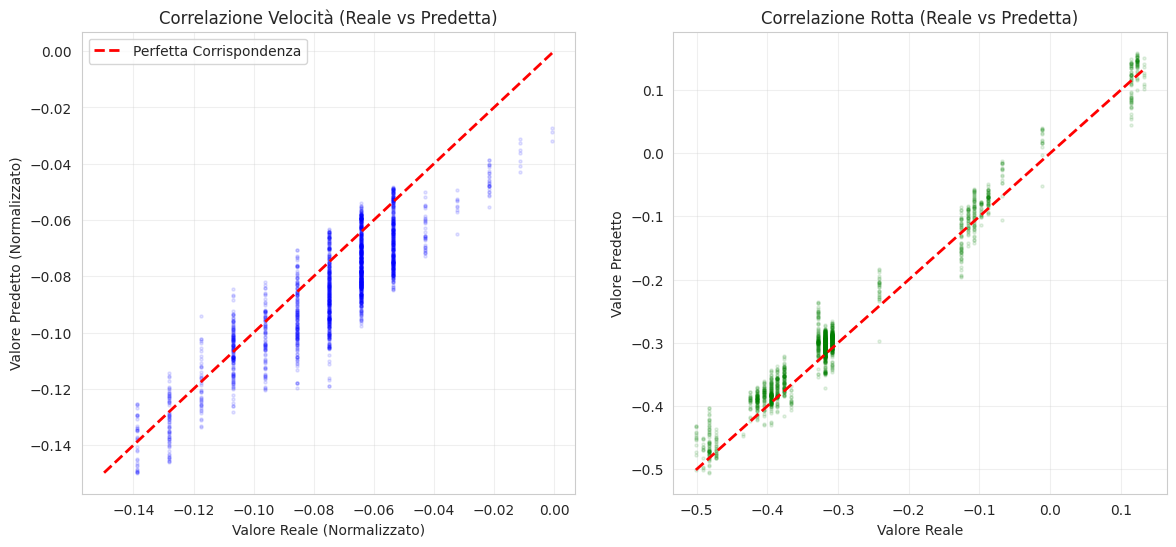

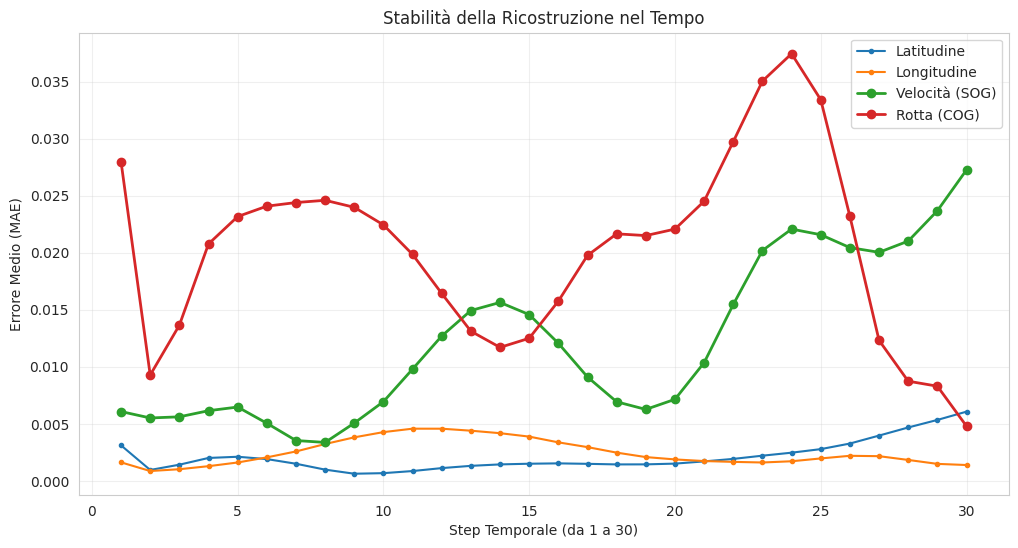

In [ ]:
X_test_batch, _ = next(test_gen)
X_pred_batch = model.predict(X_test_batch, verbose=0)

plt.figure(figsize=(14, 6))

# Plot per la Velocità (SOG)
plt.subplot(1, 2, 1)

y_true = X_test_batch[:, :, 2].flatten() # Indice 2 = SOG
y_pred = X_pred_batch[:, :, 2].flatten()

plt.scatter(y_true, y_pred, alpha=0.1, s=5, color='blue')
# Disegniamo la diagonale perfetta (Idealmente y=x)
min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfetta Corrispondenza')

plt.title("Correlazione Velocità (Reale vs Predetta)")
plt.xlabel("Valore Reale (Normalizzato)")
plt.ylabel("Valore Predetto (Normalizzato)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot per la Rotta (COG)
plt.subplot(1, 2, 2)
y_true_cog = X_test_batch[:, :, 3].flatten() # Indice 3 = COG
y_pred_cog = X_pred_batch[:, :, 3].flatten()

plt.scatter(y_true_cog, y_pred_cog, alpha=0.1, s=5, color='green')
plt.plot([min(y_true_cog), max(y_true_cog)], [min(y_true_cog), max(y_true_cog)], 'r--', linewidth=2)

plt.title("Correlazione Rotta (Reale vs Predetta)")
plt.xlabel("Valore Reale")
plt.ylabel("Valore Predetto")
plt.grid(True, alpha=0.3)

plt.show()


mae_per_step = np.mean(np.abs(X_test_batch - X_pred_batch), axis=0)

plt.figure(figsize=(12, 6))
steps = range(1, WINDOW_SIZE + 1)

plt.plot(steps, mae_per_step[:, 0], label='Latitudine', marker='.')
plt.plot(steps, mae_per_step[:, 1], label='Longitudine', marker='.')
plt.plot(steps, mae_per_step[:, 2], label='Velocità (SOG)', marker='o', linewidth=2)
plt.plot(steps, mae_per_step[:, 3], label='Rotta (COG)', marker='o', linewidth=2)

plt.title("Stabilità della Ricostruzione nel Tempo")
plt.xlabel("Step Temporale (da 1 a 30)")
plt.ylabel("Errore Medio (MAE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Analisi e Visualizzazione dello Spazio Latente
Questa sezione serve a verificare il successo del processo di codifica. L'Autoencoder è efficace se l'Encoder riesce a mappare traiettorie simili tra loro in punti vicini nello spazio latente, mentre traiettorie diverse finiscono in punti distanti.

1. **Estrazione dei Vettori Latenti**
   * **Creazione del Modello Encoder:** Viene creato un nuovo modello `encoder_model` che prende gli stessi input della rete completa, ma **la cui uscita è impostata sullo strato LSTM Encoder** (il secondo strato della rete). Questo ci permette di ispezionare direttamente il vettore latente a 32 dimensioni **(l'informazione compressa)**.
   * **Campionamento:** Vengono accumulate e processate centinaia di finestre temporali dal `test_gen` per ottenere un ampio campione di vettori latenti `latent_vectors`.

2. **Calcolo delle Caratteristiche Fisiche Rilevanti**. 
I dati di input vengono riportati alla loro scala fisica (Nodi e Gradi) tramite l'`inverse_transform`. Vengono calcolate due metriche per ogni traiettoria:
   * **Velocità Media:** La media della Velocità su Terra ($\text{SOG}$) lungo i 30 timestep.
   * **Intensità di Virata:** La deviazione standard della Rotta su Terra ($\text{COG}$) lungo i 30 timestep. Una deviazione standard alta indica una manovra complessa; una bassa indica una rotta dritta.

3. **Riduzione della Dimensionalità e Visualizzazione.** Per il plotting, viene utilizzata l'Analisi delle Componenti Principali ($\text{PCA}$). La $\text{PCA}$ riduce matematicamente i 32 valori alla seconda dimensione più informativa (Componente Principale 1 e Componente Principale 2), preservando il più possibile la loro struttura originale.
4. **Analisi dell'Output Grafico**
I due grafici tracciano i punti $\text{PCA}$ (le traiettorie) nello stesso spazio 2D, ma li colorano in base a una metrica fisica esterna:
   * **Grafico 1:** *Organizzato per Velocità* dove i punti sono colorati in base alla Velocità Media (da viola scuro per le lente a giallo brillante per le veloci). Il grafico mostra che lo spazio latente è organizzato con le **navi lente(viola/blu)** si raggruppano in certe aree (es. a sinistra), mentre **le navi veloci (giallo/verde)** si raggruppano in altre (es. a destra). La transizione è graduale e coerente. Notiamo che l'Encoder ha imparato a distinguere la Velocità come una caratteristica discriminante e ha assegnato le traiettorie in base alla loro dinamica di velocità.

   * **Grafico 2:** *Organizzato per Manovra* dove i punti sono colorati in base all'Intensità di Virata (da viola scuro per rotte dritte a giallo brillante per manovre complesse). Il grafico mostra che le traiettorie che vanno dritto (virata bassa, viola/blu scuro) sono ben separate dalle traiettorie che manovrano intensamente (virata alta, giallo/rosa). Notiamo che l'Encoder ha imparato a codificare la complessità della manovra all'interno del vettore latente.


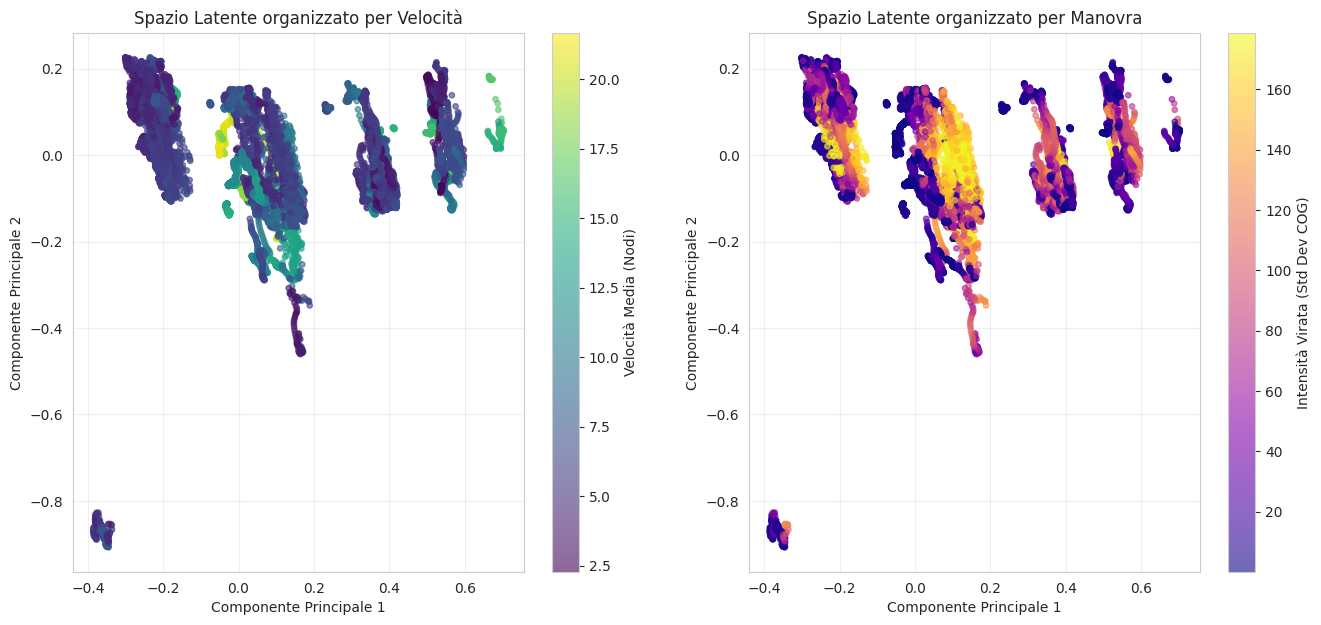

In [59]:
encoder_model = Model(inputs=model.input, outputs=model.layers[1].output)

X_batch_latent, _ = next(test_gen) 
for _ in range(500): # Accumuliamo circa 1000 campioni
    b, _ = next(test_gen)
    X_batch_latent = np.concatenate([X_batch_latent, b])

latent_vectors = encoder_model.predict(X_batch_latent, verbose=0)

X_batch_phys = scaler.inverse_transform(X_batch_latent.reshape(-1, 4)).reshape(X_batch_latent.shape)
# Calcoliamo la velocità media di ogni traiettoria
mean_speed = np.mean(X_batch_phys[:, :, 2], axis=1) 
# Calcoliamo quanto ha virato (deviazione standard del COG)
turn_intensity = np.std(X_batch_phys[:, :, 3], axis=1)

#Riduciamo a 2D con PCA per poterlo disegnare
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

#PLOT
plt.figure(figsize=(16, 7))

# Sottografico 1: Colorato per VELOCITÀ
plt.subplot(1, 2, 1)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=mean_speed, cmap='viridis', alpha=0.6, s=15)
plt.colorbar(label='Velocità Media (Nodi)')
plt.title("Spazio Latente organizzato per Velocità")
plt.xlabel("Componente Principale 1")
plt.ylabel("Componente Principale 2")
plt.grid(True, alpha=0.3)

# Sottografico 2: Colorato per VIRATA
plt.subplot(1, 2, 2)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=turn_intensity, cmap='plasma', alpha=0.6, s=15)
plt.colorbar(label='Intensità Virata (Std Dev COG)')
plt.title("Spazio Latente organizzato per Manovra")
plt.xlabel("Componente Principale 1")
plt.ylabel("Componente Principale 2")
plt.grid(True, alpha=0.3)

plt.show()

### Test di Robustezza: Denoising e Rilevamento di Errori Casuali
L'obiettivo è verificare se l'Autoencoder, addestrato solo su dati puliti, è in grado di filtrare il rumore casuale (non anomalo) presente nell'input e ricostruire fedelmente il segnale originale pulito.

1. **Preparazione dell'Input Disturbato**

   * **Estrazione Baseline:** Viene selezionata una sequenza di traiettoria normale e pulita `clean_traj` dal set di test.
   
   * **Iniezione di Rumore:** Viene generato del rumore gaussiano artificiale (noise) e aggiunto alla traiettoria pulita. Questo simula un scenario in cui i segnali GPS sono disturbati da interferenze casuali che distorcono la posizione effettiva della nave, disperdendo i punti dati su una vasta area.

   * **Input al Modello:** La traiettoria rumorosa `noisy_traj` viene quindi data in pasto al modello per la ricostruzione.

2. **Ricostruzione e Denormalizzazione:** Il modello esegue la predizione sulla sequenza disturbata e l'output `pred_from_noisy` viene denormalizzato insieme alla traiettoria pulita originale e all'input disturbato per la visualizzazione.

3. **Analisi dell'Output Grafico** 
Il grafico confronta i tre stati della traiettoria:

   * **Linea Verde Scuro (Reale Pulita):** Rappresenta la traiettoria di navigazione effettiva e ideale.

   * **Punti Blu (Input con Rumore):** Mostrano come il rumore gaussiano ha disperso i punti originali, trasformando la traiettoria pulita in un grappolo di punti caotici che non seguono un percorso chiaro.

   * **Linea Rossa Tratteggiata (Ricostruzione del Modello):** Rappresenta ciò che il modello ha "capito" e ricostruito dalla nuvola di punti blu.

   * **Risultati e Interpretazione:**

     * **Filtro del Rumore:** Si osserva che la Ricostruzione del Modello (rossa) non cerca di seguire il rumore blu sparso, ma si allinea con l'andamento del segnale Reale Pulito (verde), posizionandosi molto vicina ad esso.

     * **Generalizzazione Funzionale:** Poiché il modello è stato addestrato per apprendere la struttura fondamentale del movimento e non il rumore casuale, l'Encoder ignora i dati incoerenti e il Decoder si sforza di ricostruire la traiettoria che assomiglia di più a quelle che ha visto durante il training.

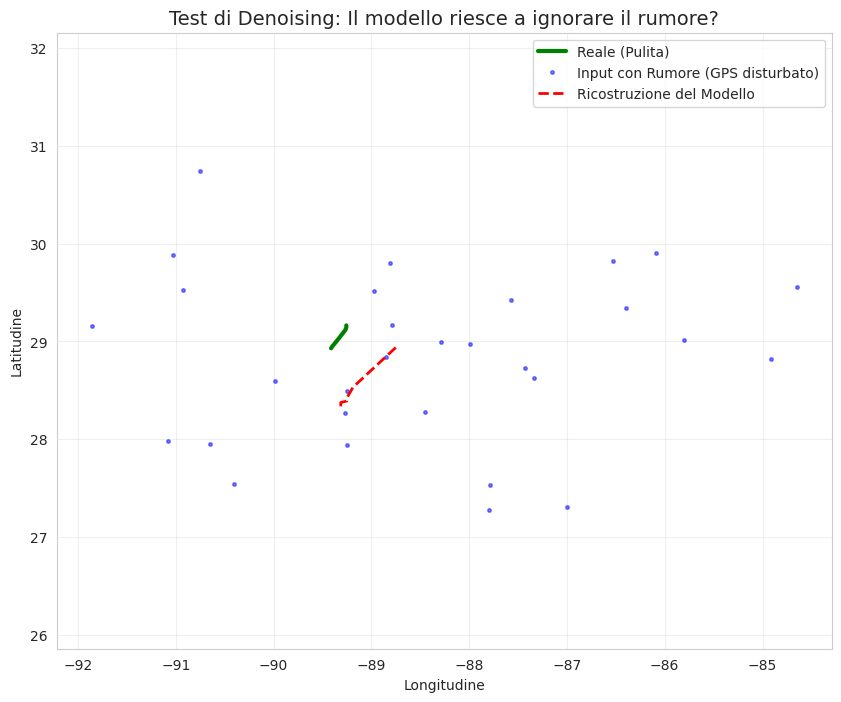

In [58]:
# Prendiamo una traiettoria pulita
idx_robust = 0
clean_traj = X_batch_latent[idx_robust]

# Aggiungiamo rumore artificiale
noise = np.random.normal(0, 0.1, clean_traj.shape) # Rumore gaussiano
noisy_traj = clean_traj + noise

# Chiediamo al modello di ricostruire quella RUMOROSA
# (Nota: il modello non ha mai visto questo rumore in addestramento!)
pred_from_noisy = model.predict(noisy_traj.reshape(1, WINDOW_SIZE, 4), verbose=0)[0]

clean_phys = scaler.inverse_transform(clean_traj)
noisy_phys = scaler.inverse_transform(noisy_traj)
pred_phys = scaler.inverse_transform(pred_from_noisy)

plt.figure(figsize=(10, 8))
plt.plot(clean_phys[:, 1], clean_phys[:, 0], 'g-', linewidth=3, label='Reale (Pulita)')
plt.plot(noisy_phys[:, 1], noisy_phys[:, 0], 'b.', markersize=5, alpha=0.5, label='Input con Rumore (GPS disturbato)')
plt.plot(pred_phys[:, 1], pred_phys[:, 0], 'r--', linewidth=2, label='Ricostruzione del Modello')

plt.title("Test di Denoising: Il modello riesce a ignorare il rumore?", fontsize=14)
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()